## 1. Import Libraries

First, we need to import the necessary libraries.

In [17]:
import os
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import json
import matplotlib.pyplot as plt

In [18]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

tf.config.run_functions_eagerly(True)

1 Physical GPUs, 1 Logical GPU


## 2. Define Directories

Next, we define the directories for the processed data and the saved models.

In [19]:
BASE_DIR = r"G:\OneDrive\ML-MinorProject\ISIC Dataset"
PROCESSED_TRAIN_DIR = os.path.join(BASE_DIR, "processed_train")
PROCESSED_VAL_DIR = os.path.join(BASE_DIR, "processed_val")
PROCESSED_TEST_DIR = os.path.join(BASE_DIR, "processed_test")
MODEL_DIR = r"G:\OneDrive\ML-MinorProject\models"
VGGNET_MODEL_PATH = os.path.join(MODEL_DIR, "vggnet", "vggnet_final_model.h5")
VGGNET_TRAINING_HISTORY=os.path.join(MODEL_DIR, "vggnet", "vggnet_training_history.json")

## 3. Image Processing Configurations and Data Augmentation

We define the image processing configurations and create data generators.

In [20]:
# Adjusted hyperparameters for VGGNet
IMG_SIZE = (224, 224)  # input size
BATCH_SIZE = 16  # batch size

# Data augmentation and preprocessing configurations
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # Preprocessing specific to MobileNetV2, normalized pixel values ranges bw [-1,1]  
    rotation_range=20,                        # Reduced rotation range as mobilenetV2 is lightweight in nature
    width_shift_range=0.1,                    # Reduced shift ranges (similar reasons)
    height_shift_range=0.1,
    shear_range=0.1,                          # manipulates the axises of the image
    zoom_range=0.1,                           # Reduced zoom
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Training data generator
train_generator = train_datagen.flow_from_directory(
    PROCESSED_TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

# Validation data generator
val_generator = val_datagen.flow_from_directory(
    PROCESSED_VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)


Found 10730 images belonging to 2 classes.
Found 2944 images belonging to 2 classes.


## 4. Visualize Data Augmentation

We visualize some augmented images to ensure that the augmentations are applied correctly.

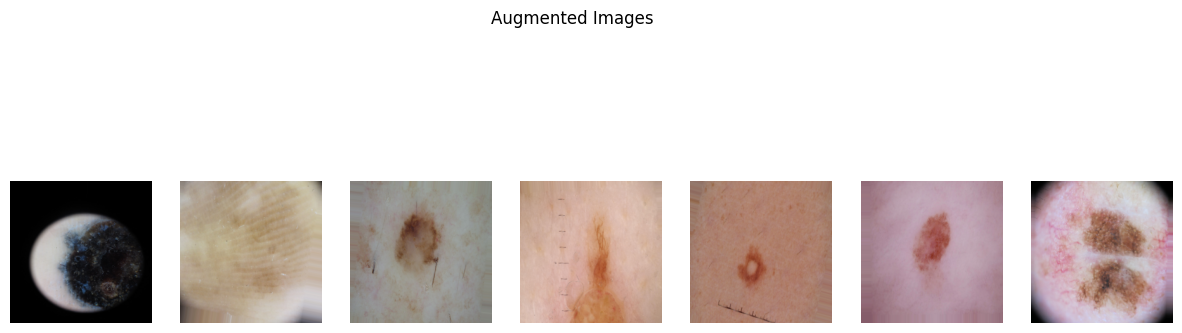

In [21]:
def visualize_augmentation(generator):
    batch = next(generator)
    images = batch[0]  # Get the batch of images (input data)

    # Denormalize images to [0, 1] range for visualization
    images = (images + 1) / 2.0  # Rescale from [-1, 1] to [0, 1]

    plt.figure(figsize=(15, 5))
    for i in range(7):
        plt.subplot(1, 7, i + 1)
        plt.imshow(images[i])  # Display the image
        plt.axis('off')
    plt.suptitle("Augmented Images")
    plt.show()

# Call the function to visualize augmented images
visualize_augmentation(train_generator)

## 5. Enable Mixed Precision

We enable mixed precision to improve training performance.

In [22]:
from tensorflow.keras import mixed_precision

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

## 6. Define and Compile Model

We define and compile the MobileNetV2 model architecture.

In [23]:
# Define the base model for MobileNetV2
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Build the full model
model = Sequential([
    base_model,                             # MobileNetV2 as the base model
    GlobalAveragePooling2D(),               # Pooling layer
    Dropout(0.5),                           # Regularization with dropout
    Dense(1, activation='sigmoid', dtype='float32')  # Binary classification
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),   # Adam optimizer with a lower learning rate
    loss='binary_crossentropy',            # Loss function for binary classification
    metrics=['accuracy']                   # Metric to track during training
)

# Display the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_2   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 513       
                                                                 
Total params: 14,715,201
Trainable params: 14,715,201
Non-trainable params: 0
_________________________________________________________________


## 7. Define Callbacks

We define callbacks to improve the training process.

In [24]:
# 1. Save the best model during training
checkpoint = ModelCheckpoint(
    filepath='mobilenetv2_best_model.h5',  # Save the model to this file
    monitor='val_loss',                   # Monitor validation loss
    save_best_only=True,                  # Save only the best model
    save_weights_only=False,              # Save the entire model
    mode='min',                           # Look for the minimum val_loss
    verbose=1                             # Print saving progress
)

# 2. Stop training early if validation loss stops improving
early_stopping = EarlyStopping(
    monitor='val_loss',                   # Monitor validation loss
    patience=10,                          # Stop after 10 epochs of no improvement
    mode='min',                           # Look for the minimum val_loss
    restore_best_weights=True,            # Restore the best weights at the end
    verbose=1                             # Print early stopping message
)

# 3. Reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',                   # Monitor validation loss
    factor=0.2,                           # Reduce the learning rate by 20%
    patience=5,                           # Wait for 5 epochs before reducing
    min_lr=1e-6,                          # Minimum learning rate
    mode='min',                           # Look for the minimum val_loss
    verbose=1                             # Print learning rate reduction message
)

# Combine the callbacks
callbacks = [checkpoint, early_stopping, reduce_lr]

## 8. Train the Model

We train the model using the data generators.

In [25]:
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=callbacks
)

Epoch 1/20


C:\Users\rikul\.conda\envs\py310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


671/671 [==============================] - ETA: 0s - loss: 0.4030 - accuracy: 0.8148
Epoch 1: val_loss improved from inf to 0.55875, saving model to mobilenetv2_best_model.h5
671/671 [==============================] - 668s 983ms/step - loss: 0.4030 - accuracy: 0.8148 - val_loss: 0.5587 - val_accuracy: 0.7561 - lr: 1.0000e-04
Epoch 2/20
671/671 [==============================] - ETA: 0s - loss: 0.3392 - accuracy: 0.8476
Epoch 2: val_loss did not improve from 0.55875
671/671 [==============================] - 655s 976ms/step - loss: 0.3392 - accuracy: 0.8476 - val_loss: 0.7191 - val_accuracy: 0.7544 - lr: 1.0000e-04
Epoch 3/20
671/671 [==============================] - ETA: 0s - loss: 0.3221 - accuracy: 0.8552
Epoch 3: val_loss did not improve from 0.55875
671/671 [==============================] - 671s 999ms/step - loss: 0.3221 - accuracy: 0.8552 - val_loss: 0.6679 - val_accuracy: 0.7609 - lr: 1.0000e-04
Epoch 4/20
671/671 [==============================] - ETA: 0s - loss: 0.3116 - accu

## 9. Fine-Tune the Model

We unfreeze the base model and fine-tune the entire model.

In [26]:
# Unfreeze the base model
base_model.trainable = True

# Recompile the model with a lower learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Fine-tune the model
fine_tune_history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=callbacks
)



Epoch 1/10
671/671 [==============================] - ETA: 0s - loss: 0.3131 - accuracy: 0.8573
Epoch 1: val_loss did not improve from 0.55875
671/671 [==============================] - 757s 1s/step - loss: 0.3131 - accuracy: 0.8573 - val_loss: 1.0790 - val_accuracy: 0.7537 - lr: 1.0000e-05
Epoch 2/10
671/671 [==============================] - ETA: 0s - loss: 0.3007 - accuracy: 0.8651
Epoch 2: val_loss did not improve from 0.55875
671/671 [==============================] - 757s 1s/step - loss: 0.3007 - accuracy: 0.8651 - val_loss: 0.8236 - val_accuracy: 0.7595 - lr: 1.0000e-05
Epoch 3/10
671/671 [==============================] - ETA: 0s - loss: 0.2892 - accuracy: 0.8656
Epoch 3: val_loss did not improve from 0.55875
671/671 [==============================] - 768s 1s/step - loss: 0.2892 - accuracy: 0.8656 - val_loss: 0.8187 - val_accuracy: 0.7639 - lr: 1.0000e-05
Epoch 4/10
671/671 [==============================] - ETA: 0s - loss: 0.2814 - accuracy: 0.8723
Epoch 4: val_loss did not im

## 10. Save the Final Model

We save the final model after training and fine-tuning.

In [27]:

model.save(VGGNET_MODEL_PATH)
print(f"Final model saved to {VGGNET_MODEL_PATH}")

Final model saved to G:\OneDrive\ML-MinorProject\models\vggnet\vggnet_final_model.h5


## 11. Save Training history
We save the training history of a model in a json file.

In [28]:
import pandas as pd
hist_df=pd.DataFrame(history.history)
with open(VGGNET_TRAINING_HISTORY, 'w') as f:
    hist_df.to_json(VGGNET_TRAINING_HISTORY)